In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys

In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
import plotly.express as px
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt

from sklearn import linear_model as lm
from sklearn.feature_selection import r_regression
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [4]:
approval = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS-FKWVTTFtJT6u56e0bqdfoMcXvDO1DUChsJ3jQAMB2lZk2SMqVfmg7dGjclTYkYWz-Pm5lfcLPjp4/pub?output=csv')
# approval = approval.reset_index()
# approval = approval.rename({'index':'poll_id'}, axis=1)
approval

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,tracking,approve,disapprove,net,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp
0,Donald Trump (2nd term),Cost,YouGov,Economist,10/24/2025,10/27/2025,1623.0,A,0.970595,0.970595,NaN,31.0,61.0,-30.0,31.21967,61.55959,-30.339920,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/27/2025,20:00:53 28 Oct 2025
1,Donald Trump (2nd term),Immigration,YouGov,Economist,10/24/2025,10/27/2025,1623.0,A,0.966633,0.966633,NaN,42.0,52.0,-10.0,42.50137,51.82990,-9.328529,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/27/2025,20:00:51 28 Oct 2025
2,Donald Trump (2nd term),Economy,YouGov,Economist,10/24/2025,10/27/2025,1623.0,A,0.966633,0.966633,NaN,35.0,57.0,-22.0,35.80633,58.10808,-22.301750,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/27/2025,20:00:49 28 Oct 2025
3,Donald Trump (2nd term),Cost,Ipsos,Reuters,10/24/2025,10/26/2025,1018.0,A,0.966645,0.913002,NaN,27.0,63.0,-36.0,30.41320,62.83666,-32.423460,https://www.reuters.com/world/us/trumps-popula...,10/26/2025,20:00:53 28 Oct 2025
4,Donald Trump (2nd term),Trade,YouGov,Economist,10/17/2025,10/20/2025,1621.0,A,1.255409,0.881925,NaN,36.0,55.0,-19.0,37.10978,55.86482,-18.755040,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/20/2025,20:00:54 28 Oct 2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,Donald Trump (2nd term),Cost,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.996709,0.000000,NaN,35.0,41.0,-6.0,38.41320,40.83666,-2.423458,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,20:00:53 28 Oct 2025
2914,Donald Trump (2nd term),Strong,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,NaN,29.0,29.0,0.0,33.22200,28.97149,4.250509,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,20:00:42 28 Oct 2025
2915,Donald Trump (2nd term),Economy,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,NaN,42.0,36.0,6.0,44.92633,36.08645,8.839882,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,20:00:49 28 Oct 2025
2916,Donald Trump (2nd term),All polls,InsiderAdvantage,NaN,1/20/2025,1/20/2025,800.0,RV,1.093180,0.000000,NaN,56.0,39.0,17.0,52.18521,42.06404,10.121170,https://insideradvantage.com/first-insideradva...,1/20/2025,20:00:30 28 Oct 2025


In [5]:
# approval[approval['pollster']=='YouGov'][approval['subgroup']=='All polls']

In [6]:
approval = approval[~approval['subgroup'].isin(['Weak', 'Strong', 'Economy', 'Cost', 'Immigration', 'Trade', 'Adults', 'Voters'])]

In [7]:
# approval.compare(pd.read_csv('trump_approval_polls.csv'))

In [8]:
# TODO: Rework this a little
compare_df = pd.merge(approval, pd.read_csv('trump_approval_polls.csv'), how='outer', indicator=True)
new_polls = compare_df[compare_df['_merge'] == 'left_only']
new_polls.shape

(628, 22)

In [9]:
del new_polls

In [10]:
approval.to_csv('trump_approval_polls.csv')

In [11]:
approval.columns.values

array(['president', 'subgroup', 'pollster', 'sponsors', 'startdate',
       'enddate', 'samplesize', 'population', 'weight', 'influence',
       'tracking', 'approve', 'disapprove', 'net', 'adjusted_approve',
       'adjusted_disapprove', 'adjusted_net', 'url', 'createddate',
       'timestamp'], dtype=object)

In [12]:
approval.shape

(628, 20)

In [13]:
# dates = approval['Dates'].str.extract(r'(\d{1,2}\/\d{1,2}) \- (\d{1,2}\/\d{1,2}), (\d{4})')
# dates

In [14]:
# dates['end_date'] = dates[1] + '/' + dates[2]
# dates['end_date'] = pd.to_datetime(dates['end_date'])
# dates

In [15]:
# approval['Dates'] = dates['end_date']
# approval.head()

In [16]:
# samples = approval['Sample'].str.extract(r'[0-9,]{3,5} (\w{1,2})@@(\d{3,4})')
# samples

In [17]:
# approval['population'] = samples[0]
# approval['sample_size'] = samples[1].astype(int)
# approval.head()

In [18]:
ratings = pd.read_csv('pollster_ratings_silver.csv')
ratings

,Pollster,Grade,Predictive Plus-Minus,Mean-reverted bias,Number of polls,cat
0,AtlasIntel,A+@@1,-0.957740,D+0.16@@0.16334188,91,D+
1,Marquette University Law School,A/B@@4,-0.920261,D+0.32@@0.31545374,17,D+
2,The Washington Post,A+@@1,-0.902281,D+0.90@@0.89811021,98,D+
3,Research & Polling Inc.,A@@2,-0.871136,R+0.55@@-0.54944503,44,R+
4,The New York Times/Siena College,A@@2,-0.763947,D+1.41@@1.4121077,116,D+
...,...,...,...,...,...,...
530,Nielson Brothers Polling,C/D@@12,1.946864,D+3.05@@3.0515239,11,D+
531,Ascend Action,C/D@@12,2.282717,D+3.35@@3.3485439,6,D+
532,Jayhawk Consulting Services,C/D@@12,2.353968,D+2.27@@2.2674108,2,D+
533,Fort Hays State University,C/D@@12,2.489170,R+1.10@@-1.0960908,6,R+


In [19]:
ratings['Pollster'].values

array(['AtlasIntel', 'Marquette University Law School',
       'The Washington Post', 'Research & Polling Inc.',
       'The New York Times/Siena College', 'Cygnal', 'SurveyUSA',
       'Siena College', 'Beacon Research/Shaw & Co. Research',
       'Alaska Survey Research', 'OnMessage Inc.', 'TIPP Insights',
       'Emerson College', 'Landmark Communications',
       'Monmouth University', 'Data Orbital',
       'University of North Florida', 'MassINC Polling Group',
       'Marist College', 'Public Policy Institute of California',
       'Public Policy Polling', 'University of California Berkeley',
       'CBS News/The New York Times', 'Christopher Newport University',
       'Mason-Dixon Polling & Strategy', 'Strategic Vision LLC',
       'Suffolk University', 'Stockton University',
       'Field Research Corp. (Field Poll)', 'Quinnipiac University',
       'Los Angeles Times',
       'Hart Research Associates/Public Opinion Strategies',
       'Public Opinion Strategies', 'Susquehan

In [20]:
ratings[ratings['Pollster'].str.contains('North Star')]#.sum()

,Pollster,Grade,Predictive Plus-Minus,Mean-reverted bias,Number of polls,cat
75,North Star Opinion Research,B/C@@8,0.043339,R+0.63@@-0.62697512,13,R+
425,Univision/Latino Decisions/North Star Opinion ...,B/C@@8,0.830409,D+1.06@@1.0564657,7,D+


In [21]:
banned_pollsters = ratings[ratings['Grade'].str.contains('F')]['Pollster'].values
banned_pollsters

array(['Strategic Vision LLC', 'Pharos Research Group', 'Research 2000',
       'Big Data Poll', 'Overtime Politics', 'Rethink Priorities',
       'Blumenthal Research Daily', 'CSP Polling', 'KG Polling',
       'OurProgress (The Progress Campaign)', 'TCJ Research'],
      dtype=object)

In [22]:
approval = approval[~approval['pollster'].isin(banned_pollsters)]
approval.shape

(628, 20)

In [23]:
approval = pd.merge(left=approval, right=ratings[['Pollster', 'Predictive Plus-Minus']], left_on='pollster',
                   right_on='Pollster', how='left')
approval

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,disapprove,net,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus
0,Donald Trump (2nd term),All polls,Quinnipiac University,NaN,10/16/2025,10/20/2025,1327.0,RV,1.384868,0.751784,...,54.0,-14.000000,42.54030,53.18279,-10.642490,https://poll.qu.edu/poll-release?releaseid=3938,10/20/2025,20:00:30 28 Oct 2025,Quinnipiac University,-0.290484
1,Donald Trump (2nd term),All polls,YouGov,Economist,10/24/2025,10/27/2025,1623.0,A,0.747146,0.747146,...,58.0,-19.000000,40.61225,57.18983,-16.577580,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/27/2025,20:00:30 28 Oct 2025,YouGov,0.047635
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/21/2025,10/27/2025,1500.0,LV,0.842577,0.740198,...,53.0,-8.000000,41.56120,54.89547,-13.334270,https://www.rasmussenreports.com/public_conten...,10/27/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015
3,Donald Trump (2nd term),All polls,YouGov,Yahoo News,10/23/2025,10/27/2025,1770.0,A,0.751537,0.706016,...,56.0,-16.000000,41.61225,55.18983,-13.577580,https://www.scribd.com/document/939641649/Yaho...,10/27/2025,20:00:30 28 Oct 2025,YouGov,0.047635
4,Donald Trump (2nd term),All polls,Morning Consult,NaN,10/24/2025,10/26/2025,2202.0,RV,0.730510,0.684362,...,51.0,-5.000000,44.70834,52.35770,-7.649361,https://pro.morningconsult.com/trackers/donald...,10/26/2025,20:00:30 28 Oct 2025,Morning Consult,0.584994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Donald Trump (2nd term),All polls,Research Co.,NaN,1/22/2025,1/24/2025,1001.0,A,0.951747,0.000000,...,46.0,4.000000,50.01817,45.41224,4.605930,https://researchco.ca/2025/01/27/immigration-usa/,1/24/2025,20:00:30 28 Oct 2025,Research Co.,0.632258
624,Donald Trump (2nd term),All polls,RMG Research,Napolitan News Service,1/20/2025,1/23/2025,3000.0,RV,0.927446,0.000000,...,39.0,18.000000,52.87422,41.85619,11.018030,https://x.com/ScottWRasmussen/status/188280455...,1/23/2025,20:00:30 28 Oct 2025,RMG Research,0.278023
625,Donald Trump (2nd term),All polls,AtlasIntel,NaN,1/21/2025,1/23/2025,1882.0,A,1.910964,0.000000,...,49.7,0.399998,49.66133,48.54790,1.113430,https://cdn.atlasintel.org/ed3f5238-e823-495e-...,1/23/2025,20:00:30 28 Oct 2025,AtlasIntel,-0.957740
626,Donald Trump (2nd term),All polls,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,...,41.0,6.000000,49.04749,39.44866,9.598827,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,20:00:30 28 Oct 2025,Ipsos,0.442898


In [24]:
approval.shape

(628, 22)

In [25]:
approval['Pollster'].value_counts()

Pollster
Rasmussen Reports                                     195
YouGov                                                 71
Morning Consult                                        49
RMG Research                                           38
Ipsos                                                  27
J.L. Partners                                          15
Global Strategy Group/GBAO (Navigator Research)        14
TIPP Insights                                          13
Echelon Insights                                       12
Quinnipiac University                                  10
Harris Insights & Analytics                            10
Gallup                                                 10
American Research Group                                 9
Emerson College                                         9
John Zogby Strategies                                   8
AtlasIntel                                              7
McLaughlin & Associates                                 6
Clari

In [26]:
# approval[~approval['tracking'].isna()]

In [27]:
approval['tracking'].value_counts()

tracking
True    202
Name: count, dtype: int64

In [28]:
# full_approval = approval.copy()

In [29]:
approval = approval[(~approval['samplesize'].isna())]
approval

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,disapprove,net,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus
0,Donald Trump (2nd term),All polls,Quinnipiac University,NaN,10/16/2025,10/20/2025,1327.0,RV,1.384868,0.751784,...,54.0,-14.000000,42.54030,53.18279,-10.642490,https://poll.qu.edu/poll-release?releaseid=3938,10/20/2025,20:00:30 28 Oct 2025,Quinnipiac University,-0.290484
1,Donald Trump (2nd term),All polls,YouGov,Economist,10/24/2025,10/27/2025,1623.0,A,0.747146,0.747146,...,58.0,-19.000000,40.61225,57.18983,-16.577580,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/27/2025,20:00:30 28 Oct 2025,YouGov,0.047635
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/21/2025,10/27/2025,1500.0,LV,0.842577,0.740198,...,53.0,-8.000000,41.56120,54.89547,-13.334270,https://www.rasmussenreports.com/public_conten...,10/27/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015
3,Donald Trump (2nd term),All polls,YouGov,Yahoo News,10/23/2025,10/27/2025,1770.0,A,0.751537,0.706016,...,56.0,-16.000000,41.61225,55.18983,-13.577580,https://www.scribd.com/document/939641649/Yaho...,10/27/2025,20:00:30 28 Oct 2025,YouGov,0.047635
4,Donald Trump (2nd term),All polls,Morning Consult,NaN,10/24/2025,10/26/2025,2202.0,RV,0.730510,0.684362,...,51.0,-5.000000,44.70834,52.35770,-7.649361,https://pro.morningconsult.com/trackers/donald...,10/26/2025,20:00:30 28 Oct 2025,Morning Consult,0.584994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Donald Trump (2nd term),All polls,Research Co.,NaN,1/22/2025,1/24/2025,1001.0,A,0.951747,0.000000,...,46.0,4.000000,50.01817,45.41224,4.605930,https://researchco.ca/2025/01/27/immigration-usa/,1/24/2025,20:00:30 28 Oct 2025,Research Co.,0.632258
624,Donald Trump (2nd term),All polls,RMG Research,Napolitan News Service,1/20/2025,1/23/2025,3000.0,RV,0.927446,0.000000,...,39.0,18.000000,52.87422,41.85619,11.018030,https://x.com/ScottWRasmussen/status/188280455...,1/23/2025,20:00:30 28 Oct 2025,RMG Research,0.278023
625,Donald Trump (2nd term),All polls,AtlasIntel,NaN,1/21/2025,1/23/2025,1882.0,A,1.910964,0.000000,...,49.7,0.399998,49.66133,48.54790,1.113430,https://cdn.atlasintel.org/ed3f5238-e823-495e-...,1/23/2025,20:00:30 28 Oct 2025,AtlasIntel,-0.957740
626,Donald Trump (2nd term),All polls,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,...,41.0,6.000000,49.04749,39.44866,9.598827,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,20:00:30 28 Oct 2025,Ipsos,0.442898


In [30]:
auxiliary = pd.read_csv('auxiliary_pollster_rating_stats.csv')
auxiliary

,Pollster,Correct calls,Outside MoE,House effect,ADPA,Herding penalty,herd_cat,p_cat
0,AtlasIntel,0.840659,8.8%@@91.208791,R+2.00@@-1.9990723,3.7@@3.6687982,0.096047,2,R+
1,The Washington Post,0.693878,6.1%@@93.877551,D+1.02@@1.0173736,3.6@@3.5756676,0.221841,3,D+
2,Research & Polling Inc.,0.886364,9.1%@@90.9090906,D+0.63@@0.63289553,4.6@@4.642076,0.286276,3,D+
3,The New York Times/Siena College,0.737069,18.1%@@81.896552,D+0.79@@0.79133403,3.2@@3.2483816,0.280332,3,D+
4,Cygnal,0.939655,13.8%@@86.206897,R+0.60@@-0.59704119,3.5@@3.4644768,0.521310,4,R+
...,...,...,...,...,...,...,...,...
93,Digital Research,0.904762,38.1%@@61.904761,R+2.44@@-2.4431372,11.4@@11.413808,0.000000,1,R+
94,Mitchell Research & Communications,0.695122,39%@@60.975611,R+0.45@@-0.44617203,4.4@@4.4410443,0.229193,3,R+
95,Merriman River Group,0.840000,60%@@39.999998,R+3.23@@-3.2347174,10.3@@10.260222,0.000000,1,R+
96,McLaughlin & Associates,0.689655,34.5%@@65.517241,R+4.94@@-4.9392128,6.2@@6.17804,0.000000,1,R+


In [31]:
# house_eff = auxiliary['House effect'].str.extract(r'(\w)\+(\d\.\d\d)@@*.')
house_eff = auxiliary['House effect'].str.extract(r'(\w)\+\d.\d\d.*@@([\d\.\+\-]+)')
house_eff[1] = house_eff[1].astype(float)
house_eff

,0,1
0,R,-1.999072
1,D,1.017374
2,D,0.632896
3,D,0.791334
4,R,-0.597041
...,...,...
93,R,-2.443137
94,R,-0.446172
95,R,-3.234717
96,R,-4.939213


In [32]:
# R --> -1, D --> 1
house_eff[0] = house_eff[0].replace({'R':-1, 'D':1})
house_eff['house_effect'] = house_eff[1]
house_eff

,0,1,house_effect
0,-1,-1.999072,-1.999072
1,1,1.017374,1.017374
2,1,0.632896,0.632896
3,1,0.791334,0.791334
4,-1,-0.597041,-0.597041
...,...,...,...
93,-1,-2.443137,-2.443137
94,-1,-0.446172,-0.446172
95,-1,-3.234717,-3.234717
96,-1,-4.939213,-4.939213


In [33]:
auxiliary['house_effect'] = house_eff['house_effect']
auxiliary = auxiliary.set_index(['Pollster'])
auxiliary

,Correct calls,Outside MoE,House effect,ADPA,Herding penalty,herd_cat,p_cat,house_effect
Pollster,,,,,,,,
AtlasIntel,0.840659,8.8%@@91.208791,R+2.00@@-1.9990723,3.7@@3.6687982,0.096047,2,R+,-1.999072
The Washington Post,0.693878,6.1%@@93.877551,D+1.02@@1.0173736,3.6@@3.5756676,0.221841,3,D+,1.017374
Research & Polling Inc.,0.886364,9.1%@@90.9090906,D+0.63@@0.63289553,4.6@@4.642076,0.286276,3,D+,0.632896
The New York Times/Siena College,0.737069,18.1%@@81.896552,D+0.79@@0.79133403,3.2@@3.2483816,0.280332,3,D+,0.791334
Cygnal,0.939655,13.8%@@86.206897,R+0.60@@-0.59704119,3.5@@3.4644768,0.521310,4,R+,-0.597041
...,...,...,...,...,...,...,...,...
Digital Research,0.904762,38.1%@@61.904761,R+2.44@@-2.4431372,11.4@@11.413808,0.000000,1,R+,-2.443137
Mitchell Research & Communications,0.695122,39%@@60.975611,R+0.45@@-0.44617203,4.4@@4.4410443,0.229193,3,R+,-0.446172
Merriman River Group,0.840000,60%@@39.999998,R+3.23@@-3.2347174,10.3@@10.260222,0.000000,1,R+,-3.234717


In [34]:
def apply_house_eff(data, pollster):
    df = data[data['pollster']==pollster]
    try:
        df['approve_adj'] = df['approve'] + (auxiliary.loc[pollster, 'house_effect'] / 2)
        df['disapprove_adj'] = df['disapprove'] - (auxiliary.loc[pollster, 'house_effect'] / 2)
    except KeyError:
        df['approve_adj'] = df['approve']
        df['disapprove_adj'] = df['disapprove']
    return df

In [35]:
pollsters = approval['pollster'].value_counts().index.values
df_adjs = []
for p in pollsters:
    df = apply_house_eff(approval, p)
    df_adjs.append(df)

approval_adj = pd.concat(df_adjs, axis=0)
approval_adj

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus,approve_adj,disapprove_adj
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/21/2025,10/27/2025,1500.0,LV,0.842577,0.740198,...,41.56120,54.89547,-13.334270,https://www.rasmussenreports.com/public_conten...,10/27/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336
21,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/17/2025,10/23/2025,1500.0,LV,0.331738,0.210363,...,43.56120,52.89547,-9.334270,https://www.rasmussenreports.com/public_conten...,10/23/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,46.361664,51.638336
26,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/20/2025,10/24/2025,1500.0,LV,0.161067,0.121868,...,42.56120,53.89547,-11.334270,https://www.rasmussenreports.com/public_conten...,10/24/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,45.361664,52.638336
30,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/10/2025,10/16/2025,1500.0,LV,0.322285,0.084555,...,45.56120,51.89547,-6.334270,https://www.rasmussenreports.com/public_conten...,10/16/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,48.361664,50.638336
32,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/16/2025,10/22/2025,1500.0,LV,0.109627,0.062635,...,44.56120,52.89547,-8.334270,https://www.rasmussenreports.com/public_conten...,10/22/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,47.361664,51.638336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Donald Trump (2nd term),All polls,Hart Research,Senate Majority PAC,10/17/2025,10/19/2025,1221.0,LV,1.177471,0.641216,...,44.62881,54.49804,-9.869228,https://senatemajority.com/wp-content/uploads/...,10/19/2025,20:00:30 28 Oct 2025,NaN,NaN,45.000000,55.000000
166,Donald Trump (2nd term),All polls,Merlin Strategy,Azoria Capital,8/11/2025,8/12/2025,2000.0,A,1.051459,0.000000,...,42.51316,50.80388,-8.290718,https://docs.google.com/spreadsheets/d/1HjSDsW...,8/12/2025,20:00:30 28 Oct 2025,NaN,NaN,42.000000,50.000000
138,Donald Trump (2nd term),All polls,Talker Research,Scripps News,8/21/2025,8/26/2025,1000.0,A,0.916470,0.000000,...,43.25885,47.74108,-4.482231,https://www.scrippsnews.com/politics/poll-vast...,8/26/2025,20:00:30 28 Oct 2025,NaN,NaN,43.000000,46.000000
102,Donald Trump (2nd term),All polls,"Normington, Petts & Associates",Third Way,9/11/2025,9/16/2025,800.0,LV,0.846329,0.000000,...,44.73734,53.77821,-9.040871,https://www.thirdway.org/memo/americans-caught...,9/16/2025,20:00:30 28 Oct 2025,"Normington, Petts & Associates",0.837728,45.000000,54.000000


In [36]:
approval.shape

(628, 22)

In [37]:
approval = approval_adj.copy()
approval.shape

(628, 24)

In [38]:
approval['poll_id'] = pd.factorize(approval['pollster'] + approval['enddate'] + approval['sponsors'].fillna('none'))[0]
approval.head(7)

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus,approve_adj,disapprove_adj,poll_id
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/21/2025,10/27/2025,1500.0,LV,0.842577,0.740198,...,54.89547,-13.33427,https://www.rasmussenreports.com/public_conten...,10/27/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336,0
21,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/17/2025,10/23/2025,1500.0,LV,0.331738,0.210363,...,52.89547,-9.33427,https://www.rasmussenreports.com/public_conten...,10/23/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,46.361664,51.638336,1
26,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/20/2025,10/24/2025,1500.0,LV,0.161067,0.121868,...,53.89547,-11.33427,https://www.rasmussenreports.com/public_conten...,10/24/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,45.361664,52.638336,2
30,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/10/2025,10/16/2025,1500.0,LV,0.322285,0.084555,...,51.89547,-6.33427,https://www.rasmussenreports.com/public_conten...,10/16/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,48.361664,50.638336,3
32,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/16/2025,10/22/2025,1500.0,LV,0.109627,0.062635,...,52.89547,-8.33427,https://www.rasmussenreports.com/public_conten...,10/22/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,47.361664,51.638336,4
36,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/15/2025,10/21/2025,1500.0,LV,0.108911,0.055330,...,51.89547,-7.33427,https://www.rasmussenreports.com/public_conten...,10/21/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,47.361664,50.638336,5
38,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/14/2025,10/20/2025,1500.0,LV,0.108630,0.048174,...,51.89547,-7.33427,https://www.rasmussenreports.com/public_conten...,10/20/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,47.361664,50.638336,6


In [39]:
approval['pollster_id'] = pd.factorize(approval['pollster'] + approval['sponsors'].fillna('none'))[0]

In [40]:
approval['population'] = approval['population'].str.strip(' ')

In [41]:
def pipeline(data: pd.DataFrame):
    dup = data[data.duplicated(subset='poll_id', keep=False)]
    ndup = data[~data.duplicated(subset='poll_id', keep=False)]
    # print('dup', dup, '\n ndup', ndup)
    dup_a = dup[dup['population'].isin(['A'])]
    # print('dup_a', dup_a)
    df = pd.concat([dup_a, ndup], axis=0)
    
    dup = df[df.duplicated(subset='poll_id', keep=False)]
    ndup = df[~df.duplicated(subset='poll_id', keep=False)]
    dup_lv = dup[dup['population'].isin(['RV'])]
    # print('dup_rv', dup_lv, 'ndup', ndup)
    df = pd.concat([dup_lv, ndup], axis=0)
    
    df['end_date'] = pd.to_datetime(df['end_date'])
    
    return df

In [42]:
approval = approval.rename({'enddate':'end_date', 'samplesize':'sample_size', 'Predictive Plus-Minus':'pred_plus_minus'}, axis=1)

In [43]:
approval['population'].value_counts().index.values

array(['LV', 'A', 'RV', 'V'], dtype=object)

In [44]:
approval.shape, pipeline(approval).shape

((628, 26), (625, 26))

In [45]:
pipeline(approval)

,president,subgroup,pollster,sponsors,startdate,end_date,sample_size,population,weight,influence,...,adjusted_net,url,createddate,timestamp,Pollster,pred_plus_minus,approve_adj,disapprove_adj,poll_id,pollster_id
65,Donald Trump (2nd term),All polls,Morning Consult,NaN,9/2/2025,2025-09-08,31492.0,A,0.953743,0.000000,...,-7.649361,https://pro.morningconsult.com/trackers/global...,9/8/2025,20:00:30 28 Oct 2025,Morning Consult,0.584994,44.629659,48.770341,271,9
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/21/2025,2025-10-27,1500.0,LV,0.842577,0.740198,...,-13.334270,https://www.rasmussenreports.com/public_conten...,10/27/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336,0,0
21,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/17/2025,2025-10-23,1500.0,LV,0.331738,0.210363,...,-9.334270,https://www.rasmussenreports.com/public_conten...,10/23/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,46.361664,51.638336,1,0
26,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/20/2025,2025-10-24,1500.0,LV,0.161067,0.121868,...,-11.334270,https://www.rasmussenreports.com/public_conten...,10/24/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,45.361664,52.638336,2,0
30,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/10/2025,2025-10-16,1500.0,LV,0.322285,0.084555,...,-6.334270,https://www.rasmussenreports.com/public_conten...,10/16/2025,20:00:30 28 Oct 2025,Rasmussen Reports,0.087015,48.361664,50.638336,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Donald Trump (2nd term),All polls,Hart Research,Senate Majority PAC,10/17/2025,2025-10-19,1221.0,LV,1.177471,0.641216,...,-9.869228,https://senatemajority.com/wp-content/uploads/...,10/19/2025,20:00:30 28 Oct 2025,NaN,NaN,45.000000,55.000000,621,85
166,Donald Trump (2nd term),All polls,Merlin Strategy,Azoria Capital,8/11/2025,2025-08-12,2000.0,A,1.051459,0.000000,...,-8.290718,https://docs.google.com/spreadsheets/d/1HjSDsW...,8/12/2025,20:00:30 28 Oct 2025,NaN,NaN,42.000000,50.000000,622,86
138,Donald Trump (2nd term),All polls,Talker Research,Scripps News,8/21/2025,2025-08-26,1000.0,A,0.916470,0.000000,...,-4.482231,https://www.scrippsnews.com/politics/poll-vast...,8/26/2025,20:00:30 28 Oct 2025,NaN,NaN,43.000000,46.000000,623,87
102,Donald Trump (2nd term),All polls,"Normington, Petts & Associates",Third Way,9/11/2025,2025-09-16,800.0,LV,0.846329,0.000000,...,-9.040871,https://www.thirdway.org/memo/americans-caught...,9/16/2025,20:00:30 28 Oct 2025,"Normington, Petts & Associates",0.837728,45.000000,54.000000,624,88


In [46]:
# approval[approval['pollster']=='Harris Insights & Analytics']

In [47]:
full_approval = approval.copy()

In [48]:
approval = approval[approval['tracking'].isna()]

In [49]:
# banned_pollsters_aux = ['Rasmussen Reports', 'co/efficient', 'TIPP Insights', 'Civiqs', 'Trafalgar Group', 'OnMessage Inc.']
banned_pollsters_aux = pd.read_csv('banned_pollsters_aux.csv')['banned_pollsters'].values
banned_pollsters_aux

array(['Rasmussen Reports', 'TIPP Insights', 'Trafalgar Group',
       'Trafalgar Group/Insider Advantage'], dtype=object)

In [50]:
approval = approval[~approval['pollster'].isin(banned_pollsters_aux)]
approval.head()

,president,subgroup,pollster,sponsors,startdate,end_date,sample_size,population,weight,influence,...,adjusted_net,url,createddate,timestamp,Pollster,pred_plus_minus,approve_adj,disapprove_adj,poll_id,pollster_id
1,Donald Trump (2nd term),All polls,YouGov,Economist,10/24/2025,10/27/2025,1623.0,A,0.747146,0.747146,...,-16.57758,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/27/2025,20:00:30 28 Oct 2025,YouGov,0.047635,39.249587,57.750413,194,2
3,Donald Trump (2nd term),All polls,YouGov,Yahoo News,10/23/2025,10/27/2025,1770.0,A,0.751537,0.706016,...,-13.57758,https://www.scribd.com/document/939641649/Yaho...,10/27/2025,20:00:30 28 Oct 2025,YouGov,0.047635,40.249587,55.750413,195,3
13,Donald Trump (2nd term),All polls,YouGov,Economist,10/17/2025,10/20/2025,1621.0,A,0.691701,0.388049,...,-14.57758,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/20/2025,20:00:30 28 Oct 2025,YouGov,0.047635,39.249587,55.750413,196,2
24,Donald Trump (2nd term),All polls,YouGov,Economist,10/10/2025,10/13/2025,1622.0,A,0.678535,0.147664,...,-12.57758,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/13/2025,20:00:30 28 Oct 2025,YouGov,0.047635,40.249587,54.750413,197,2
40,Donald Trump (2nd term),All polls,YouGov,Economist,10/4/2025,10/6/2025,1648.0,A,0.579299,0.043918,...,-14.57758,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/6/2025,20:00:30 28 Oct 2025,YouGov,0.047635,39.249587,55.750413,198,2


In [51]:
approval[approval['pollster']=='Civiqs']# [['approve', 'disapprove', 'approve_adj', 'disapprove_adj']]

,president,subgroup,pollster,sponsors,startdate,end_date,sample_size,population,weight,influence,...,adjusted_net,url,createddate,timestamp,Pollster,pred_plus_minus,approve_adj,disapprove_adj,poll_id,pollster_id
349,Donald Trump (2nd term),All polls,Civiqs,Daily Kos,5/17/2025,5/20/2025,1018.0,RV,1.120966,0.0,...,-4.640511,https://civiqs.com/documents/Civiqs_DailyKos_b...,5/20/2025,20:00:30 28 Oct 2025,Civiqs,0.158562,47.860928,51.139072,573,55
440,Donald Trump (2nd term),All polls,Civiqs,Daily Kos,4/12/2025,4/15/2025,1124.0,RV,1.149724,0.0,...,-6.640511,https://civiqs.com/reports/2025/04/17/report-a...,4/15/2025,20:00:30 28 Oct 2025,Civiqs,0.158562,46.860928,52.139072,574,55
481,Donald Trump (2nd term),All polls,Civiqs,Daily Kos,2/28/2025,3/3/2025,1031.0,RV,1.124632,0.0,...,-3.640511,https://civiqs.com/reports/2025/03/04/report-a...,3/3/2025,20:00:30 28 Oct 2025,Civiqs,0.158562,48.860928,51.139072,575,55


In [52]:
approval.columns.values

array(['president', 'subgroup', 'pollster', 'sponsors', 'startdate',
       'end_date', 'sample_size', 'population', 'weight', 'influence',
       'tracking', 'approve', 'disapprove', 'net', 'adjusted_approve',
       'adjusted_disapprove', 'adjusted_net', 'url', 'createddate',
       'timestamp', 'Pollster', 'pred_plus_minus', 'approve_adj',
       'disapprove_adj', 'poll_id', 'pollster_id'], dtype=object)

In [53]:
approval_polls = approval[['pollster', 'sponsors', 'startdate', 'end_date', 'sample_size', 'population', 'approve', 'disapprove', 'approve_adj', 'disapprove_adj', 'net', 'url', 'pred_plus_minus', 'poll_id', 'pollster_id']]
approval_polls

,pollster,sponsors,startdate,end_date,sample_size,population,approve,disapprove,approve_adj,disapprove_adj,net,url,pred_plus_minus,poll_id,pollster_id
1,YouGov,Economist,10/24/2025,10/27/2025,1623.0,A,39.0,58.0,39.249587,57.750413,-19.0,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,194,2
3,YouGov,Yahoo News,10/23/2025,10/27/2025,1770.0,A,40.0,56.0,40.249587,55.750413,-16.0,https://www.scribd.com/document/939641649/Yaho...,0.047635,195,3
13,YouGov,Economist,10/17/2025,10/20/2025,1621.0,A,39.0,56.0,39.249587,55.750413,-17.0,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,196,2
24,YouGov,Economist,10/10/2025,10/13/2025,1622.0,A,40.0,55.0,40.249587,54.750413,-15.0,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,197,2
40,YouGov,Economist,10/4/2025,10/6/2025,1648.0,A,39.0,56.0,39.249587,55.750413,-17.0,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,198,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Hart Research,Senate Majority PAC,10/17/2025,10/19/2025,1221.0,LV,45.0,55.0,45.000000,55.000000,-10.0,https://senatemajority.com/wp-content/uploads/...,NaN,621,85
166,Merlin Strategy,Azoria Capital,8/11/2025,8/12/2025,2000.0,A,42.0,50.0,42.000000,50.000000,-8.0,https://docs.google.com/spreadsheets/d/1HjSDsW...,NaN,622,86
138,Talker Research,Scripps News,8/21/2025,8/26/2025,1000.0,A,43.0,46.0,43.000000,46.000000,-3.0,https://www.scrippsnews.com/politics/poll-vast...,NaN,623,87
102,"Normington, Petts & Associates",Third Way,9/11/2025,9/16/2025,800.0,LV,45.0,54.0,45.000000,54.000000,-9.0,https://www.thirdway.org/memo/americans-caught...,0.837728,624,88


In [54]:
approval_polls.shape

(406, 15)

In [55]:
def zone_flood_checker(data, pid, date):
    """
    Check whether there are multiple polls from the same pollster + same sponsor (if applicable) within the last two weeks, 
    which could indicate "flooding the zone." Return number of polls from same pollster/sponsor in last two weeks.

    :param data: Polls dataframe.
    :param pid: Pollster ID, specified in the polls dataframe as the column pollster_id.
    :param date: Date at which specified poll is conducted. Corresponds to column end_date in polls dataframe.
    """
    thres = date - pd.Timedelta(weeks=2)
    df = data[ (data['pollster_id'] == pid) & (pd.to_datetime(data['end_date']) >= thres) ]
    return max(df.shape[0], 1)

In [56]:
def avgs_pipeline(data: pd.DataFrame, date: datetime.date):
    state_pivot = pipeline(data)
    # state_pivot['end_date'] = pd.to_datetime(state_pivot['end_date'])
    # state_pivot['pred_plus_minus'] = state_pivot['pred_plus_minus'].map(lambda x: -x)
    state_pivot = state_pivot[state_pivot['end_date'] <= pd.to_datetime(date)]
    state_pivot['population'] = state_pivot['population'].astype(str).map(lambda x: x.strip())
    
    total_num_polls = state_pivot.shape[0]

    # Sample size weights
    total_sample_size = np.sum(state_pivot['sample_size'])
    state_pivot['sample_size_weights'] = (state_pivot['sample_size'].map(lambda x: np.sqrt(min(x, 3000))) / np.sqrt(np.median(state_pivot['sample_size'].map(lambda x: min(x, 3000)))))
    # print(np.median(state_pivot['sample_size'].map(lambda x: min(x, 5000))))
    state_pivot['sample_size_weights'] /= np.sum(state_pivot['sample_size_weights'])
    
    # Time weights
    # Variation of the equation used here: https://polls.votehub.us/
    latest_date = pd.Timestamp(date)
    delta = state_pivot['end_date'].apply(lambda x: (latest_date - x).days)# (latest_date - state_pivot['end_date']).apply(lambda x: x.days)
    linear_weights = (1 - delta/((latest_date - state_pivot['end_date'].min()).days + 1))
    exp_weights = 0.1**(delta/(30))
    state_pivot['time_weights'] =  0 * linear_weights + 1 * exp_weights
    # state_pivot['time_weights'] /= np.sum(state_pivot['time_weights'])
    
    # Quality weights
    rel_quality = state_pivot['pred_plus_minus']
    def quality_weight(rel_qual):
        if np.isnan(rel_qual): # For pollsters without a quality rating from the Silver Bulletin
            return 0.2
        if rel_qual > 0.5: # Utilizing predictive plus-minus from Silver Bulletin's ratings
            return 0.2
        # return np.sqrt( (-rel_qual+1)/2.4 )+0.2
        return np.exp(-rel_qual/1.3)
    state_pivot['quality_weights'] = rel_quality.map(quality_weight)
    # state_pivot['quality_weights'] /= np.sum(state_pivot['quality_weights'])
    
    # Population weights
    def population_weight(population):
        if population == 'RV':
            return 0.8
        elif population == 'LV':
            return 0.6
        return 1
    state_pivot['population_weights'] = state_pivot['population'].map(population_weight)
    # state_pivot['population_weights'] /= np.sum(state_pivot['population_weights'])

    # Multiple polls in short window (aka "flooding the zone")
    def zone_flood_weight(pid, date):
        num_polls = zone_flood_checker(approval_polls, pid, date)
        return 1 / np.sqrt(num_polls)
    state_pivot['zone_flood_weight'] = state_pivot[['pollster_id', 'end_date']].apply(
        lambda x: zone_flood_weight(x['pollster_id'], x['end_date']),
        axis=1
    )

    # Gather the weights together
    state_pivot['total_weights'] = (state_pivot['sample_size_weights'] * state_pivot['time_weights'] * 
                                    state_pivot['quality_weights'] * state_pivot['population_weights'] * state_pivot['zone_flood_weight'])
    state_pivot['total_weights'] /= np.sum(state_pivot['total_weights']) # Normalization step
    
    return state_pivot

In [57]:
approval_polls['sample_size'].isna().any()

False

In [58]:
avgs_pipeline(approval_polls, datetime.datetime.today())

,pollster,sponsors,startdate,end_date,sample_size,population,approve,disapprove,approve_adj,disapprove_adj,...,url,pred_plus_minus,poll_id,pollster_id,sample_size_weights,time_weights,quality_weights,population_weights,zone_flood_weight,total_weights
1,YouGov,Economist,10/24/2025,2025-10-27,1623.0,A,39.0,58.0,39.249587,57.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,194,2,0.002480,9.261187e-01,0.964021,1.0,0.577350,6.812973e-02
3,YouGov,Yahoo News,10/23/2025,2025-10-27,1770.0,A,40.0,56.0,40.249587,55.750413,...,https://www.scribd.com/document/939641649/Yaho...,0.047635,195,3,0.002590,9.261187e-01,0.964021,1.0,1.000000,1.232323e-01
13,YouGov,Economist,10/17/2025,2025-10-20,1621.0,A,39.0,56.0,39.249587,55.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,196,2,0.002478,5.411695e-01,0.964021,1.0,0.500000,3.445611e-02
24,YouGov,Economist,10/10/2025,2025-10-13,1622.0,A,40.0,55.0,40.249587,54.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,197,2,0.002479,3.162278e-01,0.964021,1.0,0.447214,1.801407e-02
40,YouGov,Economist,10/4/2025,2025-10-06,1648.0,A,39.0,56.0,39.249587,55.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,198,2,0.002499,1.847850e-01,0.964021,1.0,0.408248,9.685923e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Hart Research,Senate Majority PAC,10/17/2025,2025-10-19,1221.0,LV,45.0,55.0,45.000000,55.000000,...,https://senatemajority.com/wp-content/uploads/...,NaN,621,85,0.002151,5.011872e-01,0.200000,0.6,1.000000,6.894837e-03
166,Merlin Strategy,Azoria Capital,8/11/2025,2025-08-12,2000.0,A,42.0,50.0,42.000000,50.000000,...,https://docs.google.com/spreadsheets/d/1HjSDsW...,NaN,622,86,0.002753,2.712273e-03,0.200000,1.0,1.000000,7.959087e-05
138,Talker Research,Scripps News,8/21/2025,2025-08-26,1000.0,A,43.0,46.0,43.000000,46.000000,...,https://www.scrippsnews.com/politics/poll-vast...,NaN,623,87,0.001947,7.943282e-03,0.200000,1.0,1.000000,1.648219e-04
102,"Normington, Petts & Associates",Third Way,9/11/2025,2025-09-16,800.0,LV,45.0,54.0,45.000000,54.000000,...,https://www.thirdway.org/memo/americans-caught...,0.837728,624,88,0.001741,3.981072e-02,0.200000,0.6,1.000000,4.433137e-04


In [59]:
avgs_pipeline(approval_polls, datetime.datetime.today()).shape

(406, 21)

In [60]:
def approval_over_time(data: pd.DataFrame):
    date_range = pd.date_range(start=datetime.date(2025, 1, 23), end=datetime.datetime.today(), freq='d', inclusive='both')
    yes_averages = []
    no_averages = []
    yes_stdevs = []
    no_stdevs = []
    for date in date_range:
        pipelined_df = avgs_pipeline(data, date)
        yes_avg = np.sum(pipelined_df['approve_adj'] * pipelined_df['total_weights'])
        no_avg = np.sum(pipelined_df['disapprove_adj'] * pipelined_df['total_weights'])
        yes_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['approve_adj'] - yes_avg)**2))
        no_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['disapprove_adj'] - no_avg)**2))
        yes_averages.append(yes_avg)
        no_averages.append(no_avg)
        yes_stdevs.append(yes_std)
        no_stdevs.append(no_std)
    
    return pd.DataFrame({'Date':date_range, 'Approve':yes_averages, 'Disapprove':no_averages}), pd.DataFrame({'Date':date_range, 'Approve':yes_stdevs, 'Disapprove':no_stdevs}), avgs_pipeline(data, datetime.datetime.today())

In [61]:
approval_avg, approval_std, polls_df = approval_over_time(approval_polls)
approval_avg

,Date,Approve,Disapprove
0,2025-01-23,50.817298,46.909717
1,2025-01-24,50.783638,46.348712
2,2025-01-25,50.783638,46.348712
3,2025-01-26,50.385480,46.233470
4,2025-01-27,49.232751,46.114340
...,...,...,...
274,2025-10-24,43.782499,52.605996
275,2025-10-25,43.782499,52.605996
276,2025-10-26,43.632839,52.799028
277,2025-10-27,42.917283,53.500071


In [62]:
polls_df.shape

(406, 21)

In [63]:
polls_df.head(3)

,pollster,sponsors,startdate,end_date,sample_size,population,approve,disapprove,approve_adj,disapprove_adj,...,url,pred_plus_minus,poll_id,pollster_id,sample_size_weights,time_weights,quality_weights,population_weights,zone_flood_weight,total_weights
1,YouGov,Economist,10/24/2025,2025-10-27,1623.0,A,39.0,58.0,39.249587,57.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,194,2,0.002480,0.926119,0.964021,1.0,0.57735,0.068130
3,YouGov,Yahoo News,10/23/2025,2025-10-27,1770.0,A,40.0,56.0,40.249587,55.750413,...,https://www.scribd.com/document/939641649/Yaho...,0.047635,195,3,0.002590,0.926119,0.964021,1.0,1.00000,0.123232
13,YouGov,Economist,10/17/2025,2025-10-20,1621.0,A,39.0,56.0,39.249587,55.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,196,2,0.002478,0.541170,0.964021,1.0,0.50000,0.034456


In [64]:
polls_df['net_adj'] = polls_df['approve_adj'] - polls_df['disapprove_adj']

In [65]:
display_df = polls_df[['pollster', 'sponsors', 'startdate', 'end_date', 'sample_size', 'population', 'approve', 'disapprove', 'net',
                      'total_weights', 'url']]
display_df['sponsors'] = '^Sponsor: ' + display_df['sponsors'] + '^'
display_df['sponsors'] = display_df['sponsors'].fillna('')
display_df = display_df.sort_values(['end_date'], ascending=False)
display_df = display_df.rename({'pollster':'Pollster', 'approve':'Approve', 'disapprove':'Disapprove', 'net':'Net', 'total_weights':'Weight', 'startdate':'Start Date', 'end_date':'End Date', 'url':'URL'}, axis='columns')
display_df['Sample'] = display_df['sample_size'].astype(int).astype(str) + ' ' + display_df['population']
# display_df['end_date'] = display_df['end_date'].map(lambda x: datetime.datetime.strptime(datetime.datetime.fromtimestamp(x), '%m/%d/%Y').strftime('%Y-%m-%d'))
# display_df['Date'] = pd.to_datetime(display_df['startdate']).astype(str) + ' - ' + display_df['end_date'].astype(str)
display_df['Start Date'] = pd.to_datetime(display_df['Start Date']).astype(str)
display_df['End Date'] = display_df['End Date'].astype(str)
display_df = display_df.reset_index()
# display_df = display_df.drop(['sample_size', 'population'], axis='columns')
display_df['Pollster'] = '<a href="' + display_df['URL'] + '" style="color:black; text-decoration:underline;"><u>' + display_df['Pollster'] + '</u></a>' + display_df['sponsors']
# display_df['Pollster'] = '[' + display_df['Pollster'] + '](' + display_df['URL'] + ')'
display_df = display_df[['Pollster', 'Start Date', 'End Date', 'Sample', 'Weight', 'Approve', 'Disapprove', 'Net']]
# display_df = display_df.set_index(['Pollster'])
display_df

,Pollster,Start Date,End Date,Sample,Weight,Approve,Disapprove,Net
0,"<a href=""https://d3nkl3psvxxpe9.cloudfront.net...",2025-10-24,2025-10-27,1623 A,6.812973e-02,39.0,58.0,-19.000000
1,"<a href=""https://www.scribd.com/document/93964...",2025-10-23,2025-10-27,1770 A,1.232323e-01,40.0,56.0,-16.000000
2,"<a href=""https://pro.morningconsult.com/tracke...",2025-10-24,2025-10-26,2202 RV,1.219793e-02,46.0,51.0,-5.000000
3,"<a href=""https://www.reuters.com/world/us/trum...",2025-10-24,2025-10-26,1018 A,4.515618e-02,40.0,57.0,-17.000000
4,"<a href=""https://napolitannews.org/jobapproval...",2025-10-15,2025-10-22,3000 RV,4.228585e-02,51.0,47.0,4.000000
...,...,...,...,...,...,...,...,...
401,"<a href=""https://researchco.ca/2025/01/27/immi...",2025-01-22,2025-01-24,1001 A,1.213106e-11,50.0,46.0,4.000000
402,"<a href=""https://x.com/ScottWRasmussen/status/...",2025-01-20,2025-01-23,3000 RV,1.019054e-11,57.0,39.0,18.000000
403,"<a href=""https://cdn.atlasintel.org/ed3f5238-e...",2025-01-21,2025-01-23,1882 A,6.081825e-11,50.1,49.7,0.399998
404,"<a href=""https://www.ipsos.com/en-us/reuters-i...",2025-01-20,2025-01-21,1077 A,7.255943e-12,47.0,41.0,6.000000


In [66]:
display_df.to_csv('polls_display_table.csv')

In [67]:
approval_std

,Date,Approve,Disapprove
0,2025-01-23,3.248324,5.291625
1,2025-01-24,2.883377,4.850052
2,2025-01-25,2.883377,4.850052
3,2025-01-26,3.115369,4.620733
4,2025-01-27,3.185574,4.173349
...,...,...,...
274,2025-10-24,4.036294,3.815355
275,2025-10-25,4.036294,3.815355
276,2025-10-26,3.982857,3.800809
277,2025-10-27,3.877507,3.732823


In [68]:
approval_avg['Net'] = approval_avg['Approve'] - approval_avg['Disapprove']
approval_avg

,Date,Approve,Disapprove,Net
0,2025-01-23,50.817298,46.909717,3.907581
1,2025-01-24,50.783638,46.348712,4.434926
2,2025-01-25,50.783638,46.348712,4.434926
3,2025-01-26,50.385480,46.233470,4.152009
4,2025-01-27,49.232751,46.114340,3.118411
...,...,...,...,...
274,2025-10-24,43.782499,52.605996,-8.823496
275,2025-10-25,43.782499,52.605996,-8.823496
276,2025-10-26,43.632839,52.799028,-9.166190
277,2025-10-27,42.917283,53.500071,-10.582788


In [69]:
approval_trendline = pd.merge(left=approval_avg, right=approval_std, left_on='Date', right_on='Date', how='inner')
approval_trendline['approve_CI_upper'] = approval_trendline['Approve_x'] + 1.96*approval_trendline['Approve_y']
approval_trendline['approve_CI_lower'] = approval_trendline['Approve_x'] - 1.96*approval_trendline['Approve_y']
approval_trendline['disapprove_CI_upper'] = approval_trendline['Disapprove_x'] + 1.96*approval_trendline['Disapprove_y']
approval_trendline['disapprove_CI_lower'] = approval_trendline['Disapprove_x'] - 1.96*approval_trendline['Disapprove_y']
approval_trendline = approval_trendline.rename({
    'Approve_x':'approve_mean',
    'Disapprove_x':'disapprove_mean',
}, axis='columns').drop(['Approve_y', 'Disapprove_y', 'Net'], axis='columns')
approval_trendline

,Date,approve_mean,disapprove_mean,approve_CI_upper,approve_CI_lower,disapprove_CI_upper,disapprove_CI_lower
0,2025-01-23,50.817298,46.909717,57.184012,44.450584,57.281303,36.538131
1,2025-01-24,50.783638,46.348712,56.435057,45.132220,55.854814,36.842611
2,2025-01-25,50.783638,46.348712,56.435057,45.132220,55.854814,36.842611
3,2025-01-26,50.385480,46.233470,56.491604,44.279356,55.290107,37.176834
4,2025-01-27,49.232751,46.114340,55.476476,42.989026,54.294104,37.934575
...,...,...,...,...,...,...,...
274,2025-10-24,43.782499,52.605996,51.693636,35.871362,60.084092,45.127899
275,2025-10-25,43.782499,52.605996,51.693636,35.871362,60.084092,45.127899
276,2025-10-26,43.632839,52.799028,51.439238,35.826439,60.248614,45.349442
277,2025-10-27,42.917283,53.500071,50.517196,35.317369,60.816403,46.183739


In [70]:
# Export approval ratings
approval_trendline.to_csv('approval_stats.csv')

In [71]:
polls_df.shape

(406, 22)

In [72]:
line = px.line(approval_avg, x='Date', y=['Approve', 'Disapprove'])
# scatter = px.scatter(polls_df[polls_df['end_date'] >= pd.to_datetime('2025-01-24')], x='end_date', y=['approve', 'disapprove'])
line.update_traces(hovertemplate=None)
line.update_layout(hovermode='x unified')
# scatter.update_traces(hovertemplate=None, hoverinfo='skip')
fig_approve_CI = go.Figure([
    go.Scatter(
        name='Approve CI Upper Bound',
        x = approval_avg['Date'],
        y = approval_avg['Approve'] + 1.96*approval_std['Approve'],
        mode='lines',
        marker=dict(color='#8be8f2'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),
    go.Scatter(
        name='Approve CI Lower Bound',
        x = approval_avg['Date'],
        y = approval_avg['Approve'] - 1.96*approval_std['Approve'],
        mode='lines',
        marker=dict(color='#8be8f2'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),  
])
fig_disapprove_CI = go.Figure([
    go.Scatter(
        name='Disapprove CI Upper Bound',
        x = approval_avg['Date'],
        y = approval_avg['Disapprove'] + 1.96*approval_std['Disapprove'],
        mode='lines',
        marker=dict(color='#a3cbec'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),
    go.Scatter(
        name='Disapprove CI Lower Bound',
        x = approval_avg['Date'],
        y = approval_avg['Disapprove'] - 1.96*approval_std['Disapprove'],
        mode='lines',
        marker=dict(color='#a3cbec'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),  
])

fig = go.Figure(data=line.data + fig_approve_CI.data + fig_disapprove_CI.data)
fig.update_layout(
    title='President Trump Approval Rating',
    xaxis_title='Date',
    yaxis_title='%',
    legend_title='Legend',
    hovermode='x unified'
)
fig.show()

In [73]:
line = px.line(approval_avg, x='Date', y=['Net'])
scatter = px.scatter(polls_df[polls_df['end_date'] >= pd.to_datetime('2025-01-24')], x='end_date', y=['net'])
                     #trendline='lowess', trendline_options=dict(frac=0.2))
fig = go.Figure(data=line.data + scatter.data)
fig.add_hline(y=0, line_dash='dash')
fig.show()

In [74]:
# scatter = px.scatter(polls_df[polls_df['end_date'] >= pd.to_datetime('2025-01-24')], x='end_date', y=['net', 'net_adj'])
# fig = go.Figure(data=scatter.data)
# fig.add_hline(y=0, line_dash='dash')
# fig.show()

In [75]:
def net_col(df: pd.DataFrame, min_date: datetime.date):
#     df_copy = df.set_index(['Date'])
#     return df_copy['approve_mean'] - df_copy['disapprove_mean']
    date_range = pd.date_range(start=min_date, end=datetime.datetime.today(), freq='d', inclusive='both')
    data = df.copy()
    data['net_adj'] = data['approve_adj'] - data['disapprove_adj']
    net_averages = []
    net_stdevs = []
    issue_cols = {'Date': date_range, 'net':[], 'net_std':[]}
    for date in date_range:
    #         try:
            pipelined_df = avgs_pipeline(data, date)
    #         except TypeError:
    #             print('TypeError')
    #             print(date)
            net_avg = np.sum(pipelined_df['net_adj'] * pipelined_df['total_weights'])
            net_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['net_adj'] - net_avg)**2))

            net_averages.append(net_avg)
            net_stdevs.append(net_std)

    issue_cols['net'].extend(net_averages)
    issue_cols[f'net_std'].extend(net_stdevs)
        
    net_averages, net_stdevs = [], []
        
    return pd.DataFrame(issue_cols)

In [76]:
net_approval = net_col(approval, datetime.date(2025, 1, 23))
net_approval

,Date,net,net_std
0,2025-01-23,3.907581,8.085158
1,2025-01-24,4.434926,7.277031
2,2025-01-25,4.434926,7.277031
3,2025-01-26,4.152009,7.049797
4,2025-01-27,3.118411,6.332085
...,...,...,...
274,2025-10-24,-8.823496,7.431907
275,2025-10-25,-8.823496,7.431907
276,2025-10-26,-9.166190,7.388400
277,2025-10-27,-10.582788,7.281283


In [77]:
net_approval['net_upper_CI'] = net_approval['net'] + 1.96*net_approval['net_std']
net_approval['net_lower_CI'] = net_approval['net'] - 1.96*net_approval['net_std']
net_approval

,Date,net,net_std,net_upper_CI,net_lower_CI
0,2025-01-23,3.907581,8.085158,19.754491,-11.939329
1,2025-01-24,4.434926,7.277031,18.697907,-9.828055
2,2025-01-25,4.434926,7.277031,18.697907,-9.828055
3,2025-01-26,4.152009,7.049797,17.969612,-9.665593
4,2025-01-27,3.118411,6.332085,15.529298,-9.292475
...,...,...,...,...,...
274,2025-10-24,-8.823496,7.431907,5.743042,-23.390035
275,2025-10-25,-8.823496,7.431907,5.743042,-23.390035
276,2025-10-26,-9.166190,7.388400,5.315074,-23.647454
277,2025-10-27,-10.582788,7.281283,3.688526,-24.854103


In [78]:
net_approval.to_csv('net_approval.csv')

### Auxiliary Graph: Individual Pollsters

In [80]:
approval_polls.columns.values

array(['pollster', 'sponsors', 'startdate', 'end_date', 'sample_size',
       'population', 'approve', 'disapprove', 'approve_adj',
       'disapprove_adj', 'net', 'url', 'pred_plus_minus', 'poll_id',
       'pollster_id'], dtype=object)

In [81]:
appr = full_approval.copy()
appr['net_adj'] = appr['approve'] - appr['disapprove']
appr = appr[~appr['pred_plus_minus'].isna()]
pollsters = appr['pollster'].value_counts().index.values
pollsters

array(['Rasmussen Reports', 'YouGov', 'Morning Consult', 'RMG Research',
       'Ipsos', 'J.L. Partners',
       'Global Strategy Group/GBAO (Navigator Research)', 'TIPP Insights',
       'Echelon Insights', 'Quinnipiac University', 'Gallup',
       'Harris Insights & Analytics', 'American Research Group',
       'Emerson College', 'John Zogby Strategies', 'AtlasIntel',
       'Clarity Campaign Labs', 'McLaughlin & Associates',
       'InsiderAdvantage', 'Pew Research Center',
       'Marquette University Law School', 'SSRS',
       'Beacon Research/Shaw & Co. Research', 'SurveyMonkey',
       'Hart Research Associates/Public Opinion Strategies',
       'Marist College', 'Wick', 'Leger', 'co/efficient', 'Cygnal',
       'Civiqs', 'Fabrizio Lee & Associates/Impact Research',
       'University of Massachusetts (Amherst)',
       'Public Religion Research Institute', 'OH Predictive Insights',
       'Blueprint Polling', 'High Point University', 'GBAO',
       'The New York Times/Siena Co

In [82]:
def approval_today(data: pd.DataFrame):
    # date_range = pd.date_range(start=datetime.date(2025, 1, 23), end=datetime.datetime.today(), freq='d', inclusive='both')
#     yes_averages = []
#     no_averages = []
#     yes_stdevs = []
#     no_stdevs = []
    pipelined_df = avgs_pipeline(data, datetime.datetime.today())
    yes_avg = np.sum(pipelined_df['approve'] * pipelined_df['total_weights'])
    no_avg = np.sum(pipelined_df['disapprove'] * pipelined_df['total_weights'])
    yes_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['approve'] - yes_avg)**2))
    no_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['disapprove'] - no_avg)**2))
    net_avg = np.sum(pipelined_df['net'] * pipelined_df['total_weights'])
    net_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['net'] - net_avg)**2))
    
    #return pd.DataFrame({'Date':date_range, 'Approve':yes_averages, 'Disapprove':no_averages}), pd.DataFrame({'Date':date_range, 'Approve':yes_stdevs, 'Disapprove':no_stdevs}), avgs_pipeline(data, datetime.datetime.today())
    return yes_avg, no_avg, yes_std, no_std, net_avg, net_std

In [83]:
def indiv_pollster_avg(pollster: str):
    df = appr[appr['pollster'] == pollster]
    yes_avg, no_avg, yes_std, no_std, net_avg, net_std = approval_today(df)
    return yes_avg, no_avg, yes_std, no_std, net_avg, net_std

In [84]:
def get_ppm(pollster: str):
    df = ratings[ratings['Pollster'] == pollster]
    ppm = df['Predictive Plus-Minus'].values[0]
    
    return ppm

In [85]:
appr.shape

(594, 27)

In [86]:
def get_num_polls(pollster: str):
    df = appr[appr['pollster'] == pollster]
    num_polls = df.shape[0]
    return num_polls

In [87]:
get_ppm('YouGov')

0.047635015

In [88]:
indiv_pollster_avg('YouGov')

(39.867120769707256,
 56.43639902450243,
 0.9225053734973526,
 1.0941568217786648,
 -16.56927825479518,
 1.542943275019964)

In [89]:
indiv_pollster_avg('RMG Research')

(51.2172885025721,
 47.30128592426425,
 0.5513190488148747,
 0.5459713914455964,
 3.9160025783078547,
 0.9747350676190534)

In [90]:
nets = []
net_stdevs = []
ppms = []
nums = []

for p in pollsters:
    _, _, _, _, net, net_std = indiv_pollster_avg(p)
    ppm = get_ppm(p)
    num_polls = get_num_polls(p)
    
    nets.append(net)
    net_stdevs.append(net_std)
    ppms.append(ppm)
    nums.append(num_polls)

In [91]:
# nets

In [92]:
indiv_avgs = pd.DataFrame({'Pollster': pollsters, 'Net Approval': nets, 'Net Stdev': net_stdevs, 'Predictive Plus-Minus': ppms, 'Number of Approval Polls Conducted': nums})
indiv_avgs = indiv_avgs.sort_values(['Net Approval'], ascending=True)
indiv_avgs

,Pollster,Net Approval,Net Stdev,Predictive Plus-Minus,Number of Approval Polls Conducted
12,American Research Group,-22.857799,0.514215,0.818141,9
32,University of Massachusetts (Amherst),-19.998302,0.148581,0.536200,2
19,Pew Research Center,-18.064622,0.504813,0.132230,5
1,YouGov,-16.569278,1.542943,0.047635,71
21,SSRS,-16.003280,0.114123,0.966835,5
4,Ipsos,-15.706270,1.654188,0.442898,27
9,Quinnipiac University,-14.166086,0.600263,-0.290484,10
33,Public Religion Research Institute,-13.999994,0.004078,0.103864,2
20,Marquette University Law School,-13.987017,0.228121,-0.920261,5
10,Gallup,-13.222578,0.801125,-0.096810,10


In [93]:
indiv_avgs.to_csv('indiv_pollster_avgs.csv')

In [94]:
reg = lm.LinearRegression()
reg.fit(indiv_avgs[['Predictive Plus-Minus']], indiv_avgs['Net Approval'])
reg.coef_, reg.intercept_

(array([-2.97020227]), -6.437142787895309)

In [95]:
r = r_regression(indiv_avgs[['Predictive Plus-Minus']], indiv_avgs['Net Approval'])
r

array([-0.22992318])

In [96]:
net_approval['net'].diff()

0           NaN
1      0.527345
2      0.000000
3     -0.282917
4     -1.033598
         ...   
274    0.000000
275    0.000000
276   -0.342693
277   -1.416598
278    0.000000
Name: net, Length: 279, dtype: float64

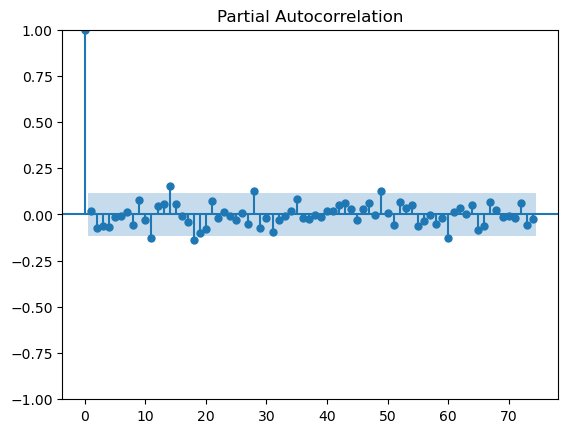

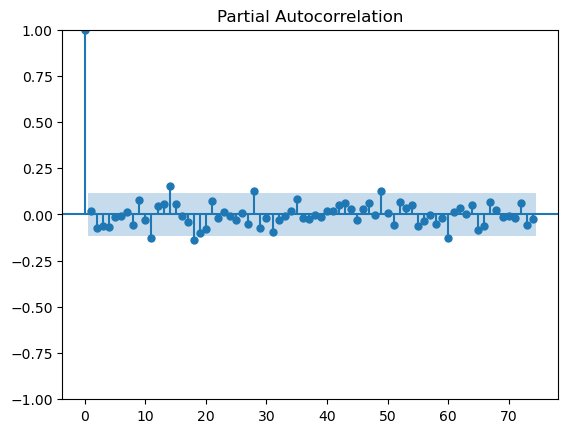

In [97]:
plot_pacf(net_approval['net'].diff()[1:], lags=np.arange(75))

In [98]:
armod_sm = AutoReg(net_approval['net'].diff()[1:].values, lags = 1, trend = 'c').fit()
# print(armod_sm.summary())

In [99]:
armod_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  278
Model:                     AutoReg(1)   Log Likelihood                -206.323
Method:               Conditional MLE   S.D. of innovations              0.510
Date:                Tue, 28 Oct 2025   AIC                            418.646
Time:                        17:56:31   BIC                            429.518
Sample:                             1   HQIC                           423.008
                                  278                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0533      0.031     -1.733      0.083      -0.114       0.007
y.L1           0.0166      0.060      0.277      0.782      -0.101       0.134
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           60.1995           +0.0000j           60.1995            0.0000
-----------------------------------------------------------------------------
"""

In [100]:
k, n_train = 15, 208
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([-0.0533466 , -0.07281817, -0.02931636, -0.0533466 , -0.0533466 ,
       -0.05530317, -0.07116498, -0.03604512, -0.0533466 , -0.04391108,
       -0.0533466 , -0.0533466 , -0.05511813, -0.05665147, -0.04806885])